# Description

The notebook automates the process of pushing a pair of scenarios (baseline and alternative) through the simulation and optimization pipeline, comparing outputs for each scenario. Key outputs include harvested area (hectares), harvested volume (m³), and growth (m³). The notebook also reports stand age class distribution, old growth attributes, and tree species diversity at the beginning and end of the planning horizon for each scenario. Additionally, it calculates biodiversity and socioeconomic indicators, while quantifying differences between baseline and alternative scenarios in terms of carbon stocks and net emissions over a customizable simulation horizon, set to 100 years by default (the system can easily be parametrized to simulate shorter or longer horizons).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import os
from util import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events, cbm_report_both, compare_ws3_cbm_both

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
import time
from functools import partial, wraps
import distance
import operator
import shutil
import os
import math

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age, epsilon_computer, tradeoff_biodiversity_cs, tradeoff_hv_cs, tradeoff_hv_biodiversity

In [5]:
# Initialize the input parameters
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [6]:
# Input paths
shapefile_path = './data/shp_files/tsa17.shp/stands selection.shp'

# Output paths
stands_csv_path = './data/stands.csv'
curve_points_table_csv_path = './data/curve_points_table.csv'

yldmerged_csv_path = './data/yldmerged.csv'

woodstock_model_files_lan_path = './data/woodstock_model_files_ecotrust/ecotrust.lan'
woodstock_model_files_are_path = './data/woodstock_model_files_ecotrust/ecotrust.are'
woodstock_model_files_yld_path = './data/woodstock_model_files_ecotrust/ecotrust.yld'
woodstock_model_files_act_path = './data/woodstock_model_files_ecotrust/ecotrust.act'
woodstock_model_files_trn_path = './data/woodstock_model_files_ecotrust/ecotrust.trn'
contributing_area_path = './data/woodstock_model_files_ecotrust/aoi.txt'

In [7]:
# Load the CSV file
file_path = "./data/AACs.csv"  # Update with your file path if needed
df = pd.read_csv(file_path)

# Convert to dictionary where TSA is the key and AAC is the value
aac_dict = dict(zip(df['TSA'], df['AAC']))

# Display the resulting dictionary
print(aac_dict)


{'tsa01': 500000, 'tsa02': 670142, 'tsa03': 840331, 'tsa04': 119791, 'tsa05': 808000, 'tsa07': 485000, 'tsa08': 2582350, 'tsa09': 424800, 'tsa10': 329024, 'tsa11': 2100000, 'tsa12': 1087000, 'tsa13': 550000, 'tsa14': 970000, 'tsa15': 375000, 'tsa16': 2321476, 'tsa17': 337574, 'tsa18': 1200000, 'tsa20': 1576043, 'tsa22': 2462800, 'tsa23': 967805, 'tsa24': 6935023, 'tsa25': 272061, 'tsa26': 2607000, 'tsa27': 225000, 'tsa29': 2937509, 'tsa30': 1220808, 'tsa31': 368276, 'tsa38': 315694, 'tsa39': 1050000, 'tsa40': 2115000, 'tsa41': 1791846, 'tsa43': 865000, 'tsa44': 845286, 'tsa45': 346920}


In [8]:
# Define scenario options based on case study


scenario_options = {

    'test': ['evenflow_cons', 'no_cons'],
    'ecotrust': ['lowest carbon stock', 'business as usual', '40% of highest carbon stock', '60% of highest carbon stock', '20% of highest carbon stock', 'highest carbon stock']
}
# scenario_options = {

#     'test': ['evenflow_cons'],
#     'ecotrust': ['business as usual', '40% of highest carbon stock']
# }
# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value


case_study_dropdown = widgets.Dropdown(
    options=['test', 'ecotrust'],
    value='ecotrust',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['ecotrust'],  # Set initial options based on default case study
    value=scenario_options['ecotrust'][0],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_hv',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=1, options=('test', 'ecotrust'), value='ecotrust')

Dropdown(description='Scenario:', options=('lowest carbon stock', 'business as usual', '40% of highest carbon …

Dropdown(description='Objective:', options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_hv')

In [9]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=0, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=0, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [10]:
#Start Calculating the Running Time
Start = time.time()

In [11]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [12]:
hwp_pool_effect_value

0.0

In [13]:
obj_mode

'max_hv'

In [14]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'test': {
        'model_name': 'ecotrust',
        'model_path': './data/woodstock_model_files_ecotrust'
    },
    'ecotrust': {
        'model_name': 'ecotrust',
        'model_path': './data/woodstock_model_files_ecotrust'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [15]:
stands_org = gpd.read_file(shapefile_path)
stands_org['forest_type'] = stands_org.apply(
    lambda row: 1 if row['age2015'] > (60 + 10) else 2,
    axis=1
)

In [16]:
columns_to_keep = ['theme0', 'thlb', 'au', 'ldspp', 'age2015', 'shape_area', 'geometry','forest_type']
stands = stands_org[columns_to_keep].copy()
# stands['theme0'] = 'tsa01'
columns = ['theme0'] + \
          [col for col in stands.columns if col not in ['theme0', 'forest_type']]  # Exclude these two
columns.insert(4, 'forest_type')  # Insert 'primary_forest' at the 4th position
stands = stands[columns]  # Apply new order

In [17]:
stands = stands.rename(columns={'thlb': 'theme1', 'au': 'theme2', 'ldspp': 'theme3', 'forest_type': 'theme5', 'age2015': 'age', 'shape_area': 'area' })

In [18]:
stands['area'] = stands.geometry.area * 0.0001
# This code changes the type of "theme2" into integer
stands['theme2'] = stands['theme2'].astype(int)
# stands = ensure_missing_values(stands)
stands.insert(4, 'theme4', stands['theme2'])


In [19]:
# Reading yld table and changing AU column type into integer
yld = pd.read_csv('./data/yld.csv')
yld['AU'] = yld['AU'].astype(int)


In [20]:
# Creating AU table from stands table and renaming the column to AU. The AU table is then joined with yld table.
AU = pd.DataFrame(stands['theme2']).drop_duplicates()
AU.rename(columns = {'theme2':'AU'},inplace=True)
# Inner joining AU and yld tables. The results of the code will be a yield table (yldmerged) that has AU column.
yldmerged = pd.merge(AU, yld, on=['AU'], how='inner')

In [21]:
# Getting names and codes of canfi_species. This table will be used to add canfi_species column into yldmerged
canf = pd.read_csv('data/canfi_species_revised.csv')
canf = canf[['name','canfi_species']].set_index('name')

In [22]:
yldmerged['canfi_species'] = yldmerged.apply(lambda row: canf.loc[row['LDSPP'], 'canfi_species'], axis=1)

In [23]:
# replacing leading species names with their codes
for index, row in stands.iterrows():
    stands.at[index,'theme6'] = canf.loc[row['theme3'],'canfi_species']
stands['theme3'] = stands['theme6']
# stands = stands.drop('theme6',axis=1)
# stands['theme4'] = stands['theme2']
stands['theme3'] = stands['theme3'] .astype(int)

In [24]:
# stands = ensure_missing_values(stands)
# stands.insert(5, 'theme5', stands['theme4'])
total_area = stands[stands['theme1'] == 1]['area'].sum()


In [25]:
curve_points_table = yldmerged
# Adding 'curve_id' and 'canfi_species' columns to curve_points_table
curve_points_table ['curve_id'] = curve_points_table ['AU']
curve_points_table ['canfi_species'] = yldmerged ['canfi_species'].astype(int)

In [26]:
columns_to_index_yld = ['AU']

In [27]:
curve_points_table = curve_points_table.set_index(columns_to_index_yld)

In [28]:
# stands_.to_csv(stands_csv_path, index=False)
# stands_mdf.to_csv(stands_mdf_csv_path, index=False)
# yld_vdyp.to_csv(yld_vdyp_csv_path, index=False)
yldmerged.to_csv(yldmerged_csv_path, header=True, index=False)
stands.to_csv(stands_csv_path, header=True, index=False)
curve_points_table.to_csv(curve_points_table_csv_path, header=True, index=False)

In [29]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AUs
            'theme3', # leading species code
            'theme4',  # yield curve ID
            'theme5',  # forest type
           ]
basecodes = [list(map(lambda x: str(x), stands[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands['theme3'].astype(str))))
# basecodes[4] = list(set(basecodes[4] + list((stands['theme2'] * 1000 + 1).astype(str)) + list((stands['theme2'] * 1000 + 2).astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands['theme4'].astype(str))))
basecodes[5] = list(set(basecodes[5] + list(stands['theme5'].astype(str))))

In [30]:
fm = ws3.forest.ForestModel(model_name='ecotest',
                            model_path='data',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [31]:
for ti, t in enumerate(theme_cols):
    fm.add_theme(t, basecodes[ti])

In [32]:
gstands = stands.groupby(theme_cols+['age'])

In [33]:
age_cutoff = 600
for name, group in gstands:
    dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
    if dtk not in fm.dtypes:
        fm.dtypes[dtk] = ws3.forest.DevelopmentType(dtk, fm)
    fm.dtypes[dtk].area(0, age, area)

In [34]:
curve_points_table['forest_type'] = 1
new_rows = curve_points_table.copy()
new_rows["forest_type"] += 1

# Combine original and new rows
curve_points_table = pd.concat([curve_points_table, new_rows]).sort_index().reset_index(drop=True)


In [35]:
tot=[]
swd=[]
hwd=[]
for AU, au_row in curve_points_table.iterrows():
    yname = 's%04d' % int(au_row.canfi_species)    
    curve_id = au_row.curve_id
    forest_type = au_row.forest_type
    mask = ('?', '?', str(curve_id), '?', str(curve_id), str(forest_type))
    points = [(x*10, int(au_row['X%i' % (x*10)])) for x in range(36)]
    c = fm.register_curve(ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length))
    # print('*Y', ' '.join(v for v in mask), file=file)
    # print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 350, 10)), file=file)
    fm.yields.append((mask, 'a', [(yname, c)])) # only if not already present?
    fm.ynames.add(yname) 
    for dtk in fm.unmask(mask): 
        fm.dtypes[dtk].add_ycomp('a', yname, c)
    
    if yname not in tot:
        tot.append(yname)
    if int(au_row.canfi_species) > 1200:
        if yname not in hwd: hwd.append(yname)
    else:
        if yname not in swd: swd.append(yname)

In [36]:
expr = '_SUM(%s)' % ', '.join(fm.ynames)
expr_h = '_SUM(%s)' % ', '.join(hwd)
expr_s = '_SUM(%s)' % ', '.join(swd)
ycomps = [(tvy_name, expr), ('swdvol', expr_s), ('hwdvol', expr_h)]
fm.yields.append((('?', '?', '?', '?', '?', '?'), 'c', ycomps))
fm.ynames.update([tvy_name, 'swdvol', 'hwdvol'])
# for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', tvy_name, expr)  
for k in fm.unmask(('?', '?', '?', '?', '?', '?')):
    for yname, ycomp in ycomps:
        fm.dtypes[k].add_ycomp('c', yname, ycomp)

In [37]:

acode = 'harvest'
oe = '_age >= 90 and _age <= 600' # operability expression
# print('*CASE', acode, file=file)
fm.transitions[acode] = {}
record_au = set()
for au_id, au_row in stands.iterrows():
    if au_row.theme2 in record_au: continue
    if not au_row.theme1: continue
    au = au_row.theme2
    target_curve_id = au
    smask = ('?', '1' , str(au), '?', '?', '?')
    tmask = ('?', '?' , '?', '?', str(target_curve_id), '2')
    target = [(tmask, 1.0, None, None, None, None, None)] # list of one (single target... not modelling "divergent" transitions)
    fm.actions[acode] = ws3.forest.Action(acode, targetage=0, is_harvest=True)
    fm.oper_expr[acode] = {smask:oe}        
    fm.transitions[acode].update({smask:{'':target}}) # the '' is a blank source 
    # import pdb; pdb.set_trace()
    record_au.add(au_row.theme2)   
    for dtk in fm.unmask(smask):
        dt = fm.dtypes[dtk]
        dt.oper_expr[acode] = [oe]
        fm.dtypes[dtk].transitions[acode, -1] = target       

In [38]:
fm.compile_actions()

In [39]:
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [40]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [41]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping,
                                       include_empty_dtypes=True)

In [42]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_emissionstock(sit_config, sit_tables, n_steps)

In [43]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [44]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [45]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

In [46]:
sit_yield = sit_tables['sit_yield']


In [47]:
sit_events = sit_tables['sit_events']

In [48]:
sit_inventory = sit_tables['sit_inventory']

In [49]:
# Set Age and Area to 1 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [50]:
sit_tables['sit_inventory'] = df

In [51]:
# Run CBM and Generate CBM 0utputs
cbm_output_curves = run_cbm_emissionstock(sit_config, sit_tables, n_steps=700)

In [52]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [53]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [54]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [55]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [56]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [57]:
c_curves_f['total_emission'] = 44/12 * c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [58]:
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [59]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for ecotrust_max_hv_lowest carbon stock...
running lowest carbon stock scenario


/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


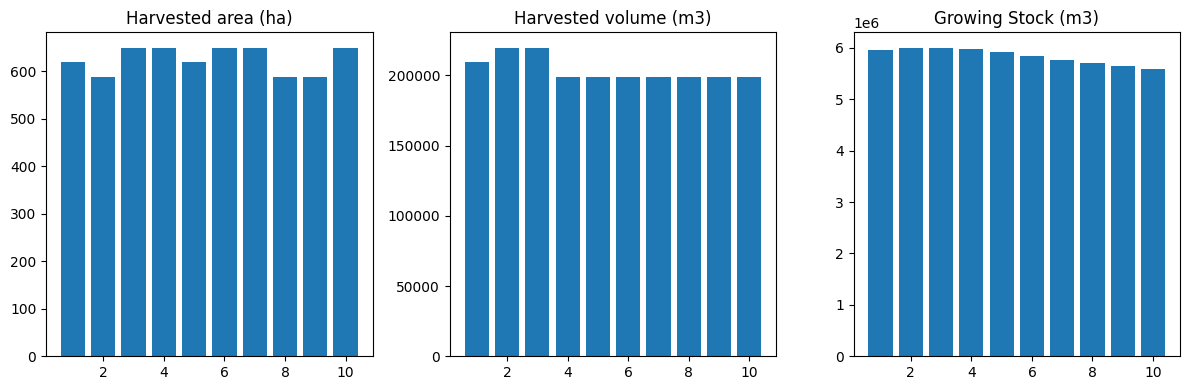

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_lowest carbon stock_scheduling.pdf


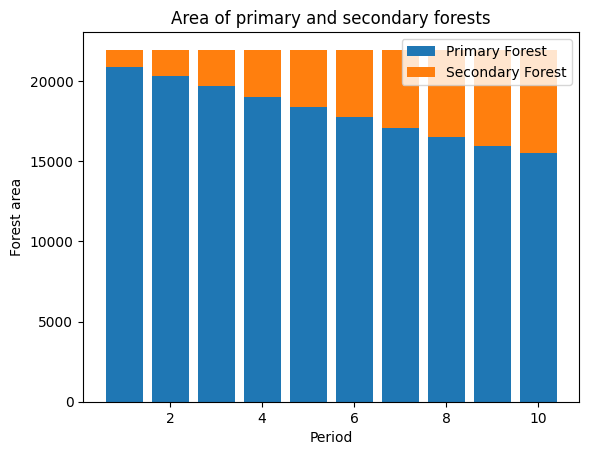

------------------------------------------------
The scocial indicator (the number of job creation) is:  2155
The economic indicator (the provincial government revenues) is:  73512
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_lowest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   766.593449   310.730965
Aspen      75.149189   219.719674   144.570484
Cedar     398.274360  1585.246720  1186.972360
Pine      159.807528   156.418549    -3.388979
Bal      3394.884493  4624.189899  1229.305406
Spruce   4649.351742  4457.271722  -192.080020
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1166.227693   136.081332

Old growth has **increased** by 2833.41 hectares from time period 0 to ti

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


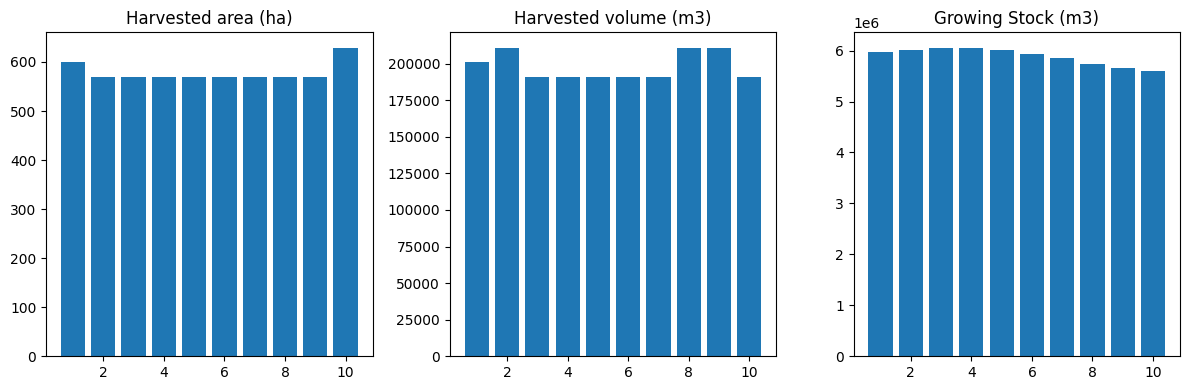

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


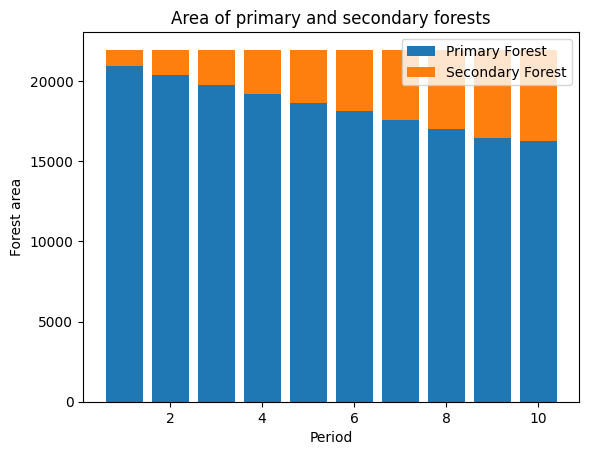

------------------------------------------------
The scocial indicator (the number of job creation) is:  2091
The economic indicator (the provincial government revenues) is:  71321
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   732.606055   276.743571
Aspen      75.149189   201.083815   125.934626
Cedar     398.274360  1297.315617   899.041256
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5069.289647  1674.405154
Spruce   4649.351742  5257.164280   607.812538
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1436.838879   406.692518

Old growth has **increased** by 4056.62 hectares from time period 0 to time

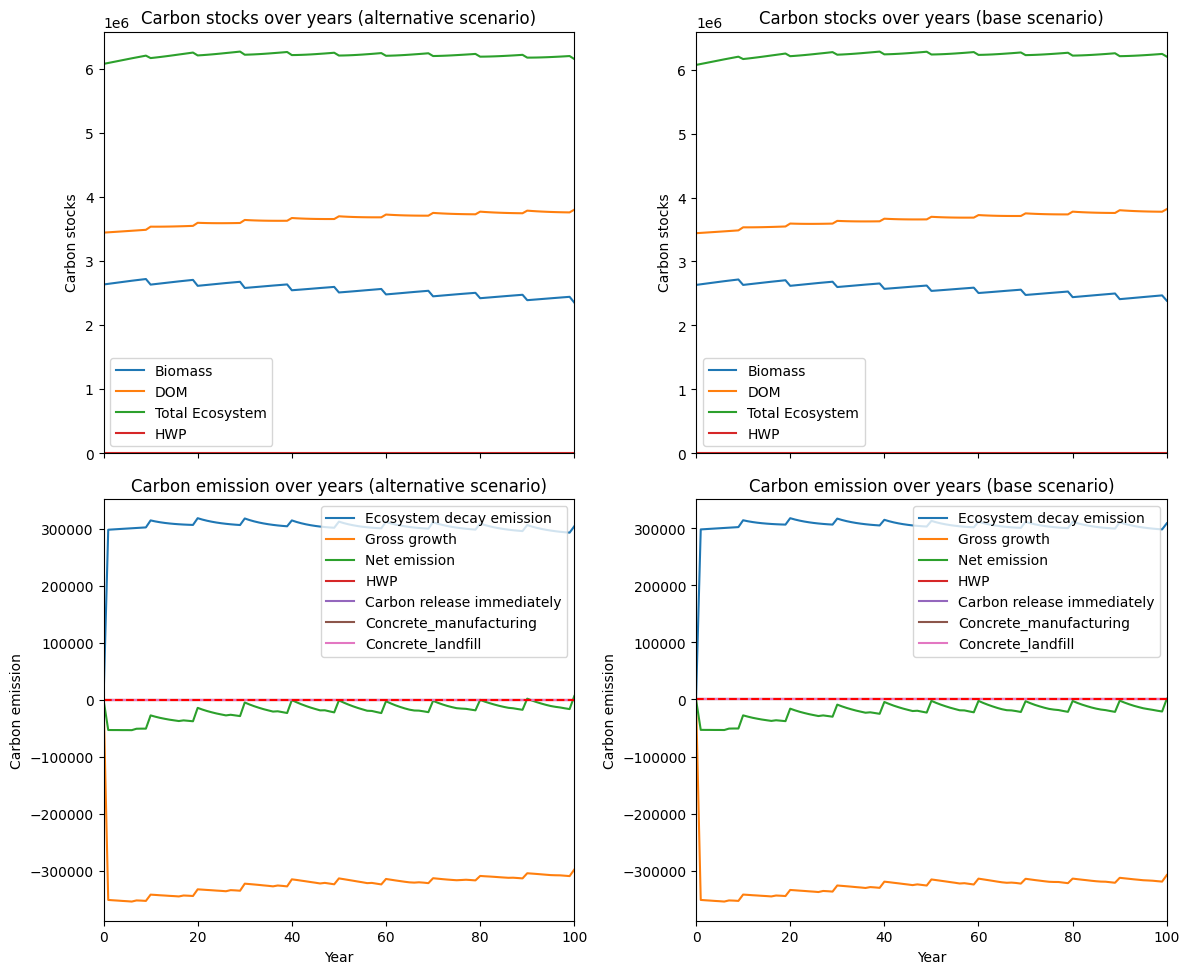

---------------------------------------------------------------------------------------
Net emission difference 153697.76170845598
Net emission base scenario -2100094.913723152
Net emission alternative scenario -1946397.1520146963
dollar_per_ton is:  65.06275620960999
Comparison of Old Growth Areas (Alternative - Base)
           0          10  Difference
DougFir  0.0   33.987394   33.987394
Aspen    0.0   18.635859   18.635859
Cedar    0.0  287.931104  287.931104
Pine     0.0  -48.159397  -48.159397
Bal      0.0 -445.099748 -445.099748
Spruce   0.0 -799.892558 -799.892558
Birch    0.0    0.000000    0.000000
Hem      0.0 -270.611186 -270.611186

Overall, the old growth area has **decreased** by -1223.21 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
--------------------------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


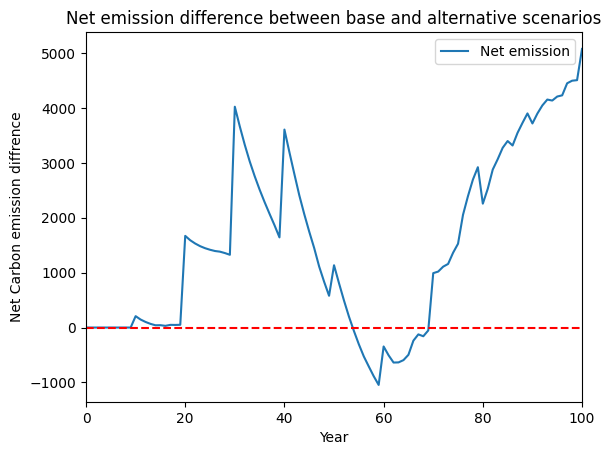

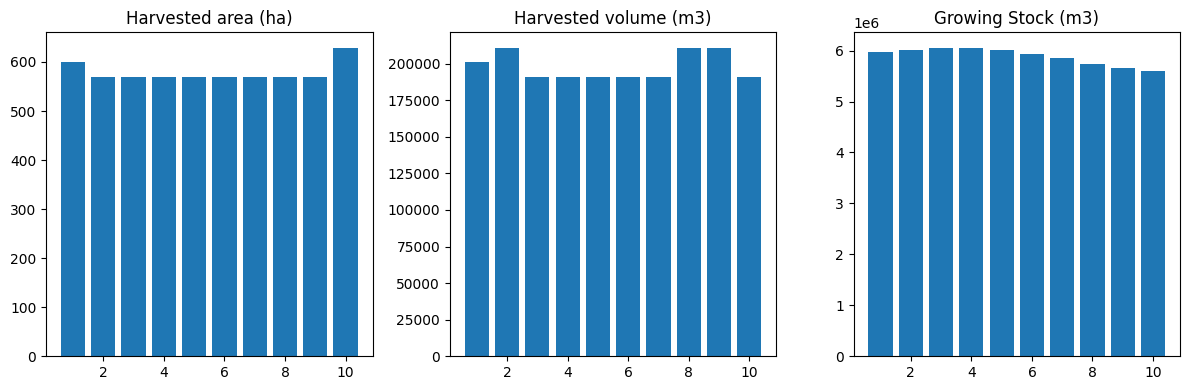

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


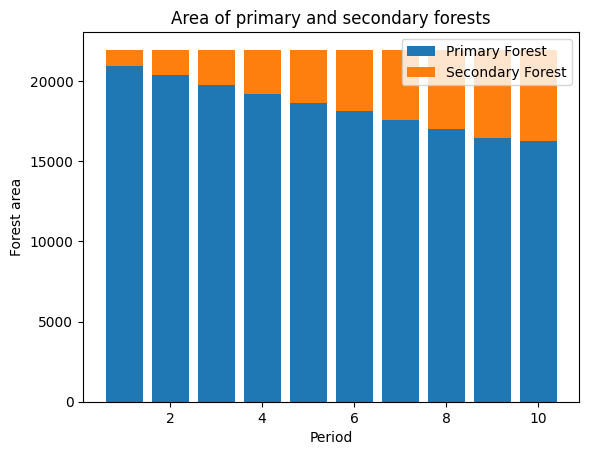

------------------------------------------------
The scocial indicator (the number of job creation) is:  2091
The economic indicator (the provincial government revenues) is:  71321
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   732.606055   276.743571
Aspen      75.149189   201.083815   125.934626
Cedar     398.274360  1297.315617   899.041256
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5069.289647  1674.405154
Spruce   4649.351742  5257.164280   607.812538
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1436.838879   406.692518

Old growth has **increased** by 4056.62 hectares from time period 0 to time

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


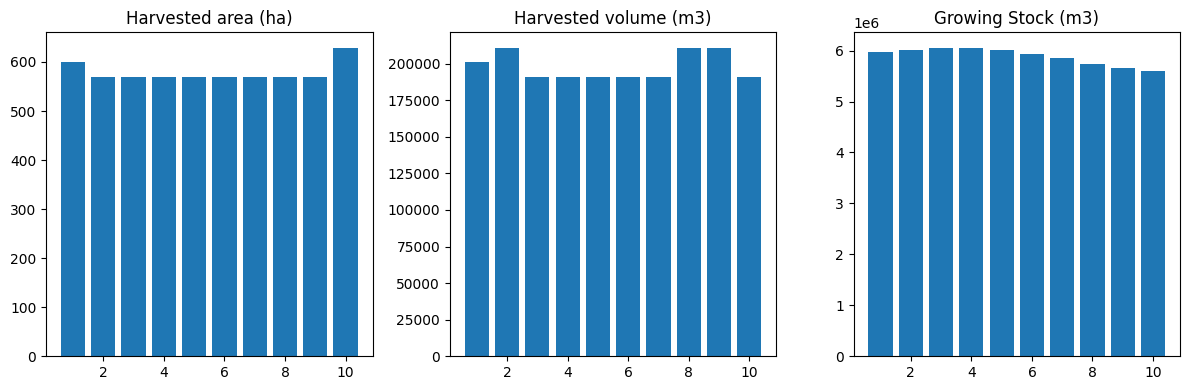

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


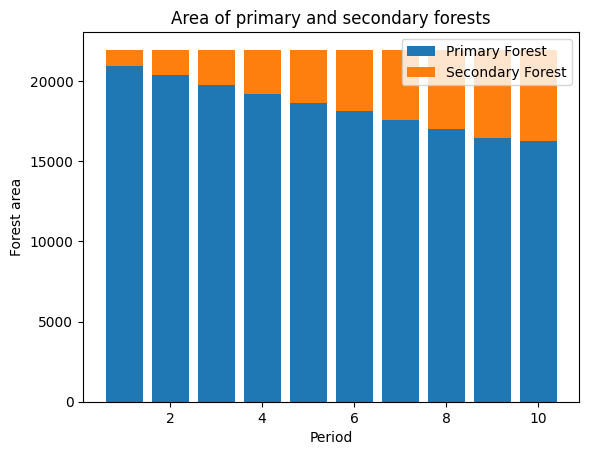

------------------------------------------------
The scocial indicator (the number of job creation) is:  2091
The economic indicator (the provincial government revenues) is:  71321
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   732.606055   276.743571
Aspen      75.149189   201.083815   125.934626
Cedar     398.274360  1297.315617   899.041256
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5069.289647  1674.405154
Spruce   4649.351742  5257.164280   607.812538
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1436.838879   406.692518

Old growth has **increased** by 4056.62 hectares from time period 0 to time

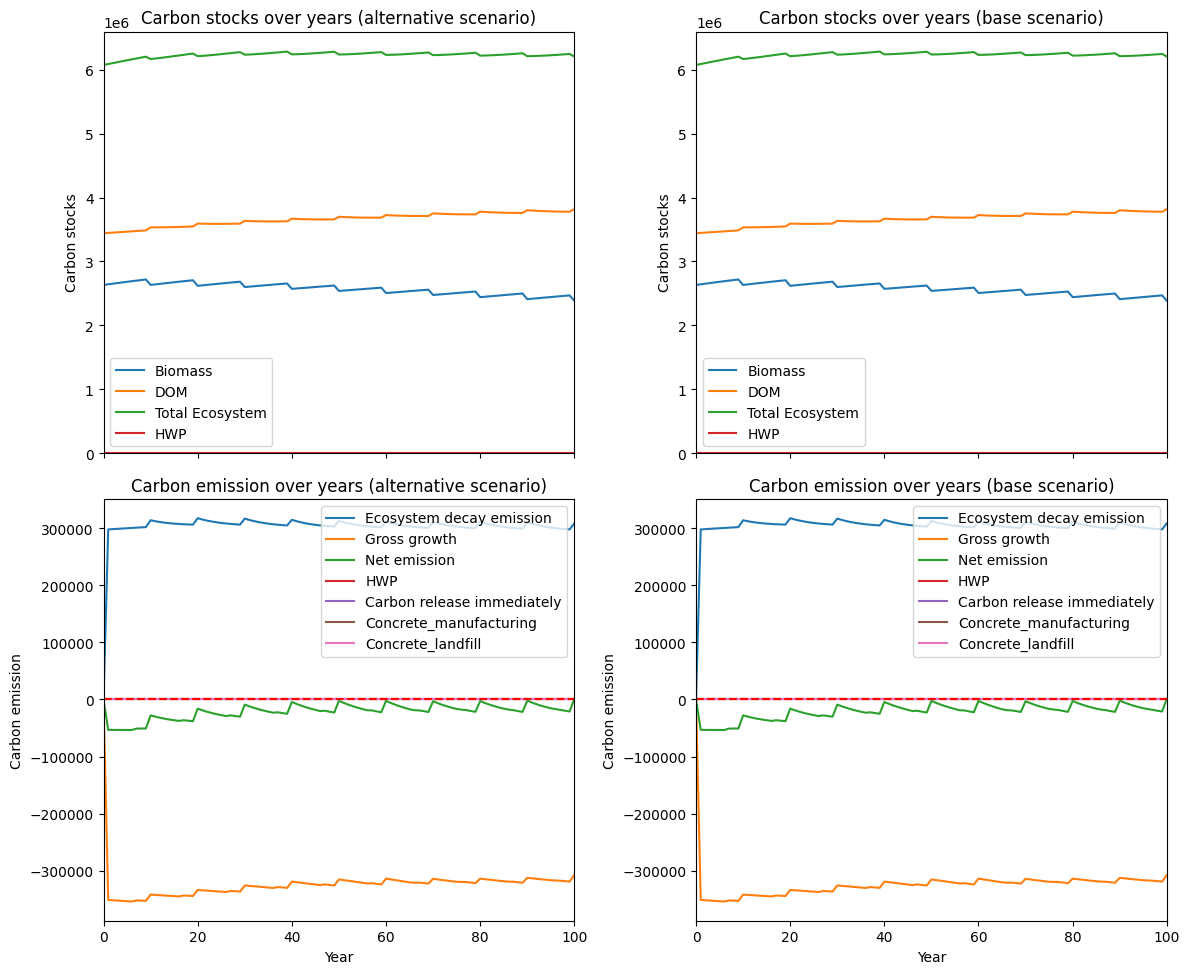

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -2100094.913723152
Net emission alternative scenario -2100094.913723152
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
           0   10  Difference
DougFir  0.0  0.0         0.0
Aspen    0.0  0.0         0.0
Cedar    0.0  0.0         0.0
Pine     0.0  0.0         0.0
Bal      0.0  0.0         0.0
Spruce   0.0  0.0         0.0
Birch    0.0  0.0         0.0
Hem      0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/sghotb/ecotrust-dss/util.py:1482: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario['Net emission'].sum()) # Calculate for the next 25 years


Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for ecotrust_max_hv_40% of highest carbon stock...
running 40% of highest carbon stock scenario


/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


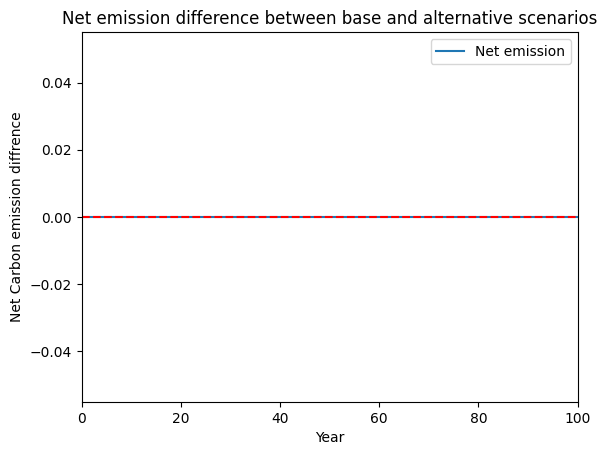

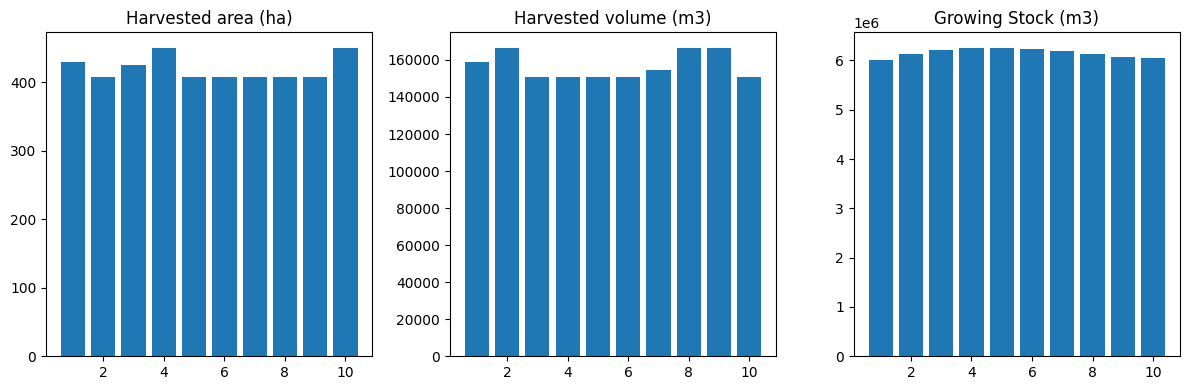

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_40% of highest carbon stock_scheduling.pdf


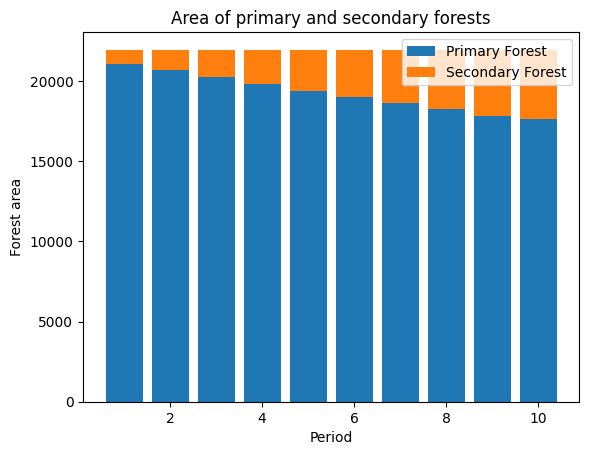

------------------------------------------------
The scocial indicator (the number of job creation) is:  1656
The economic indicator (the provincial government revenues) is:  56475
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_40% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   794.016664   338.154180
Aspen      75.149189   289.462382   214.313193
Cedar     398.274360  1742.180942  1343.906582
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5152.373194  1757.488701
Spruce   4649.351742  5491.129720   841.777978
Birch       5.900812    41.142246    35.241434
Hem      1030.146361  1548.008604   517.862243

Old growth has **increased** by 5093.51 hectares from time period

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


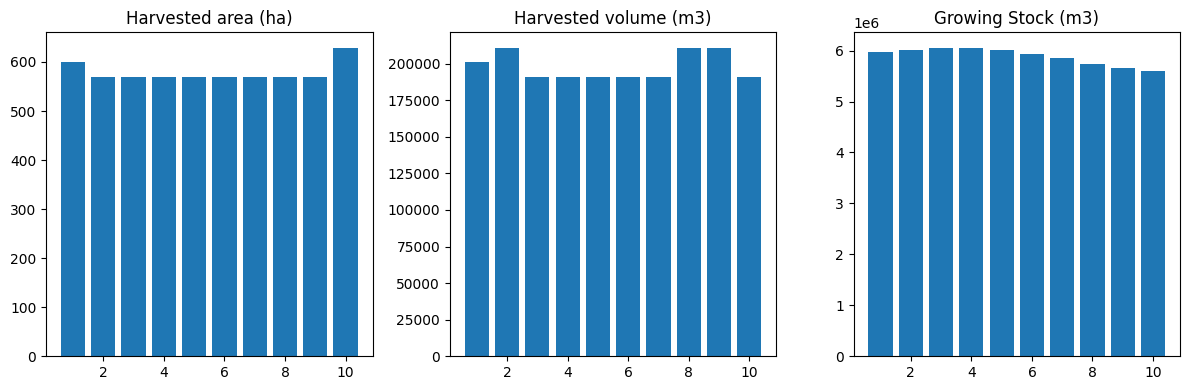

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


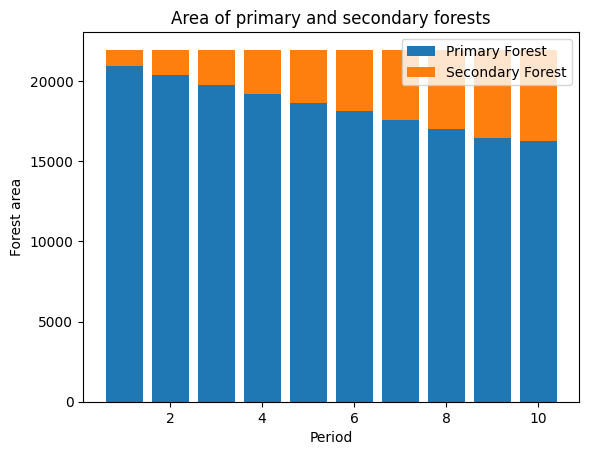

------------------------------------------------
The scocial indicator (the number of job creation) is:  2091
The economic indicator (the provincial government revenues) is:  71321
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   732.606055   276.743571
Aspen      75.149189   201.083815   125.934626
Cedar     398.274360  1297.315617   899.041256
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5069.289647  1674.405154
Spruce   4649.351742  5257.164280   607.812538
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1436.838879   406.692518

Old growth has **increased** by 4056.62 hectares from time period 0 to time

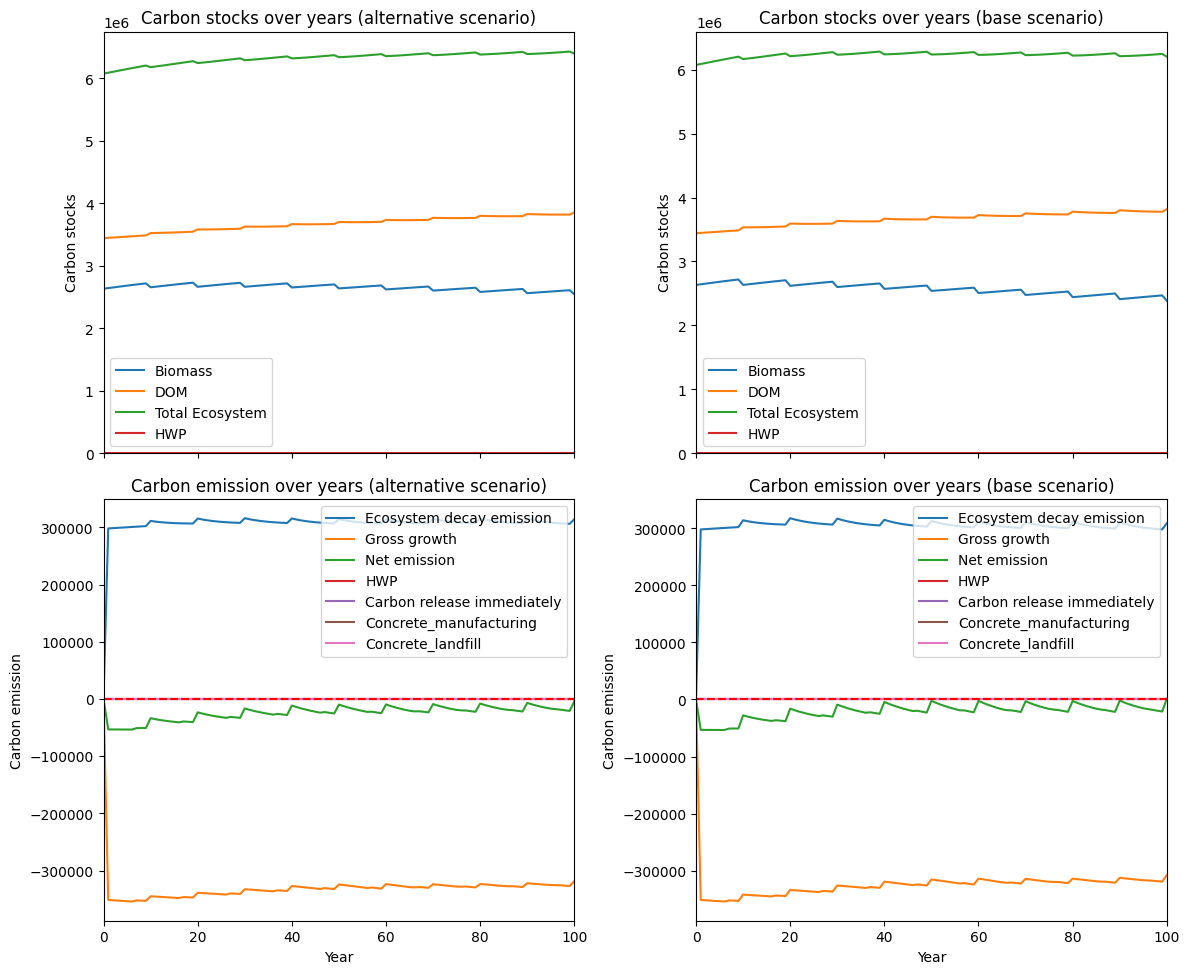

---------------------------------------------------------------------------------------
Net emission difference -350555.11032484676
Net emission base scenario -2100094.913723152
Net emission alternative scenario -2450650.0240479987
dollar_per_ton is:  28.526185200191094
Comparison of Old Growth Areas (Alternative - Base)
           0          10  Difference
DougFir  0.0   61.410609   61.410609
Aspen    0.0   88.378567   88.378567
Cedar    0.0  444.865326  444.865326
Pine     0.0    0.000000    0.000000
Bal      0.0   83.083547   83.083547
Spruce   0.0  233.965440  233.965440
Birch    0.0   14.026344   14.026344
Hem      0.0  111.169725  111.169725

Overall, the old growth area has **increased** by 1036.90 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
-------------------------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


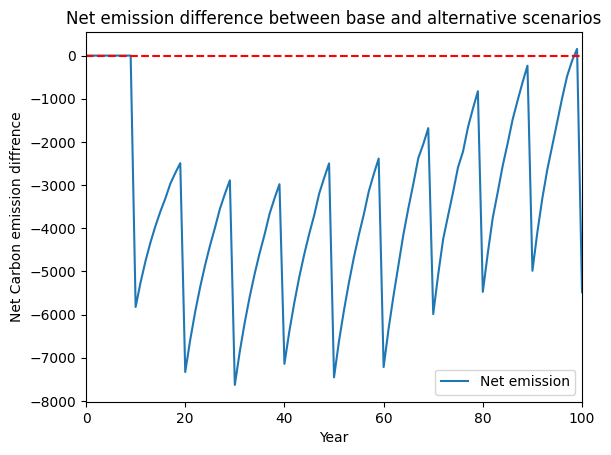

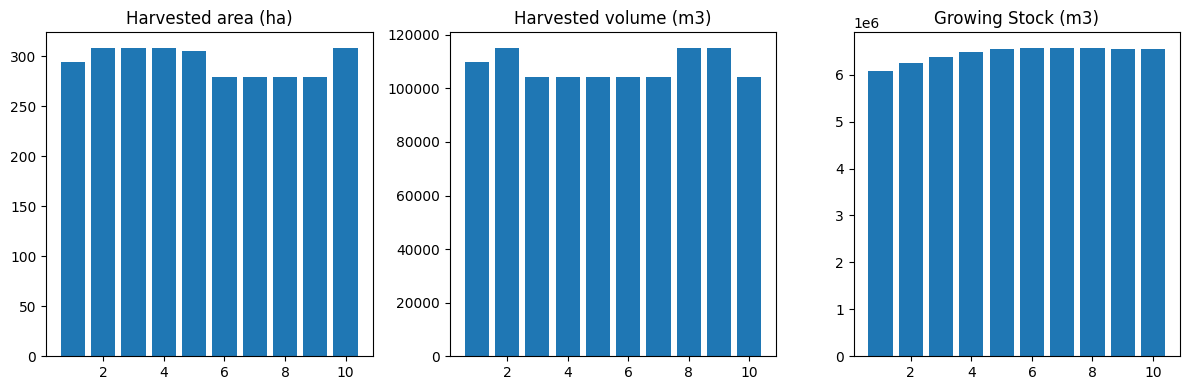

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_60% of highest carbon stock_scheduling.pdf


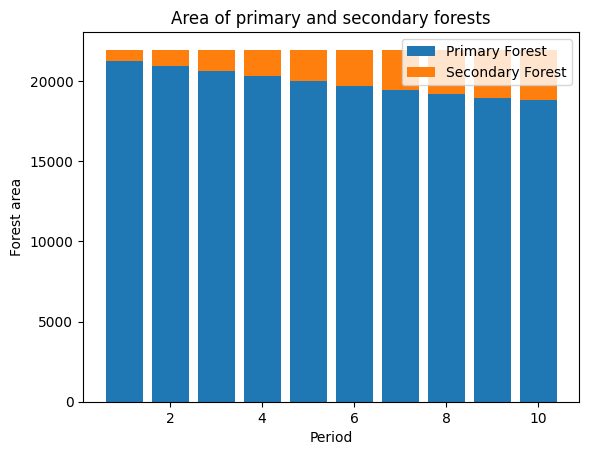

------------------------------------------------
The scocial indicator (the number of job creation) is:  1142
The economic indicator (the provincial government revenues) is:  38951
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_60% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483  1074.306683   618.444200
Aspen      75.149189   289.462382   214.313193
Cedar     398.274360  1816.220377  1417.946017
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5203.849626  1808.965133
Spruce   4649.351742  6164.941857  1515.590114
Birch       5.900812    41.142246    35.241434
Hem      1030.146361  1548.008604   517.862243

Old growth has **increased** by 6173.13 hectares from time period

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


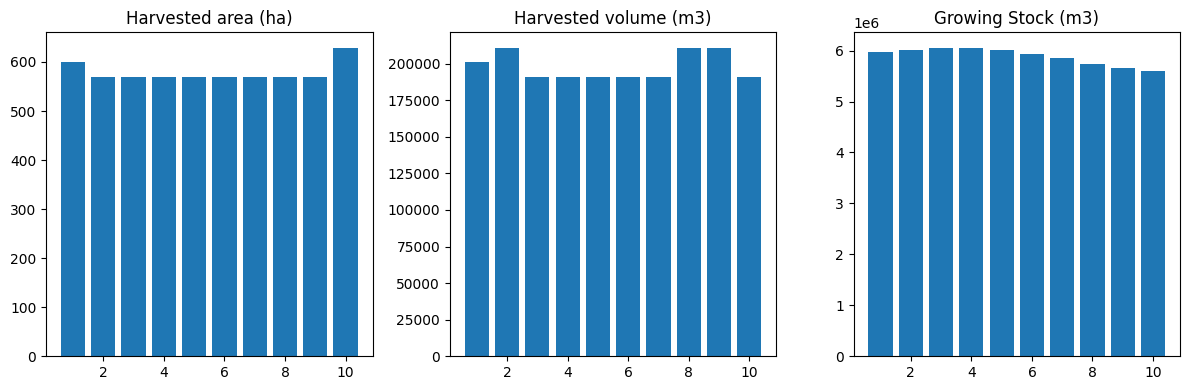

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


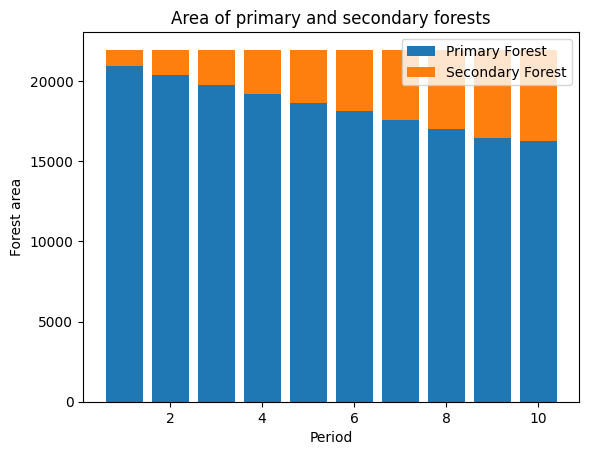

------------------------------------------------
The scocial indicator (the number of job creation) is:  2091
The economic indicator (the provincial government revenues) is:  71321
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   732.606055   276.743571
Aspen      75.149189   201.083815   125.934626
Cedar     398.274360  1297.315617   899.041256
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5069.289647  1674.405154
Spruce   4649.351742  5257.164280   607.812538
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1436.838879   406.692518

Old growth has **increased** by 4056.62 hectares from time period 0 to time

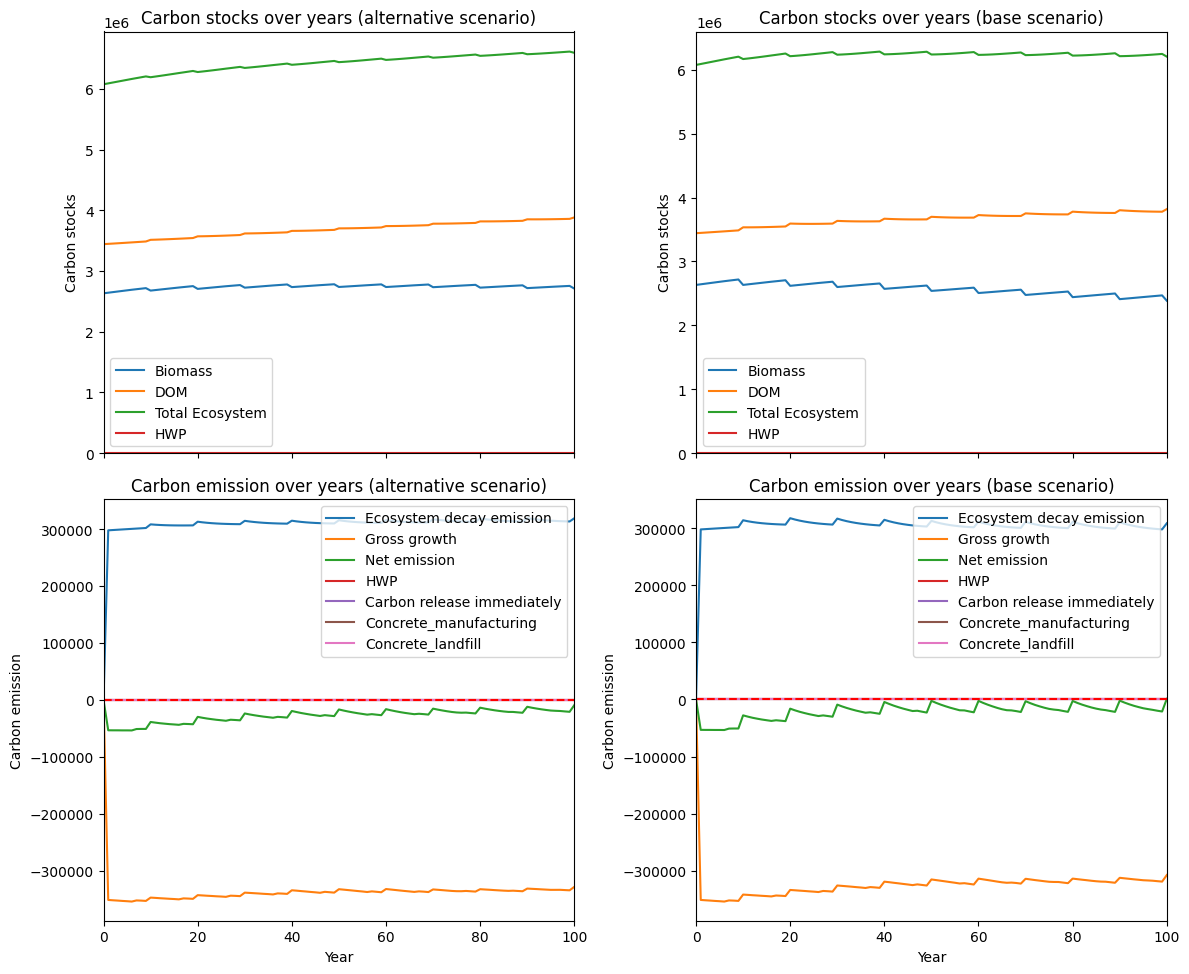

---------------------------------------------------------------------------------------
Net emission difference -691002.5657359163
Net emission base scenario -2100094.913723152
Net emission alternative scenario -2791097.4794590687
dollar_per_ton is:  14.471726294315596
Comparison of Old Growth Areas (Alternative - Base)
           0          10  Difference
DougFir  0.0  341.700628  341.700628
Aspen    0.0   88.378567   88.378567
Cedar    0.0  518.904760  518.904760
Pine     0.0    0.000000    0.000000
Bal      0.0  134.559979  134.559979
Spruce   0.0  907.777577  907.777577
Birch    0.0   14.026344   14.026344
Hem      0.0  111.169725  111.169725

Overall, the old growth area has **increased** by 2116.52 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
--------------------------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


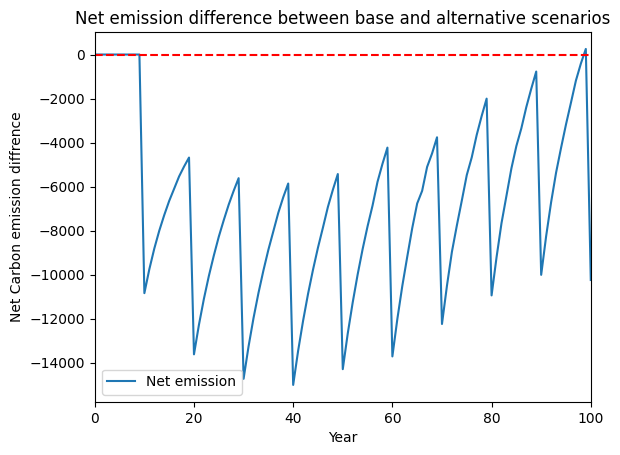

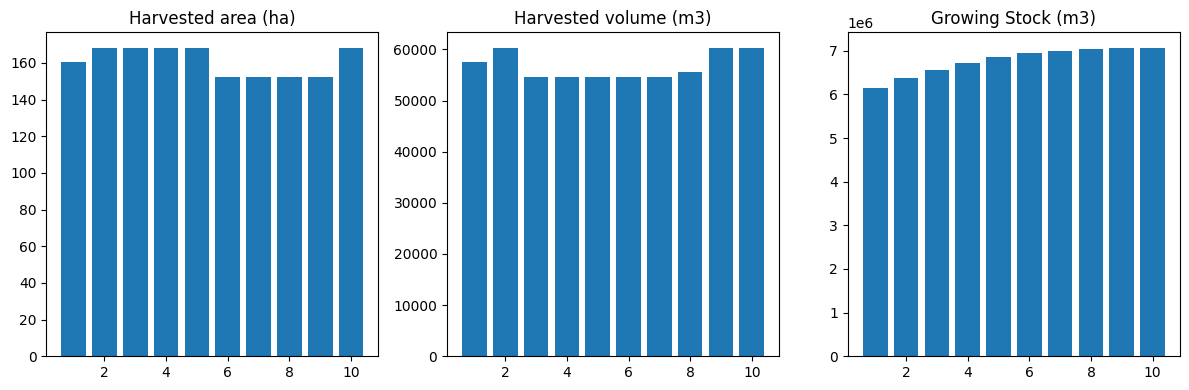

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_20% of highest carbon stock_scheduling.pdf


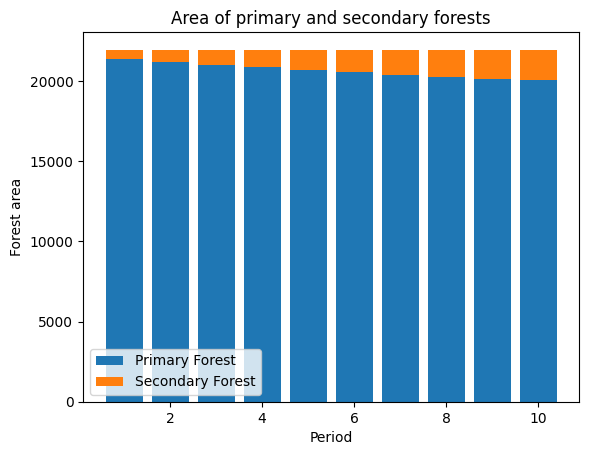

------------------------------------------------
The scocial indicator (the number of job creation) is:  599
The economic indicator (the provincial government revenues) is:  20434
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_20% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483  1263.427441   807.564958
Aspen      75.149189   336.070589   260.921400
Cedar     398.274360  1848.549030  1450.274670
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5203.849626  1808.965133
Spruce   4649.351742  6850.375184  2201.023441
Birch       5.900812    41.142246    35.241434
Hem      1030.146361  1554.354448   524.208087

Old growth has **increased** by 7132.97 hectares from time period 

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


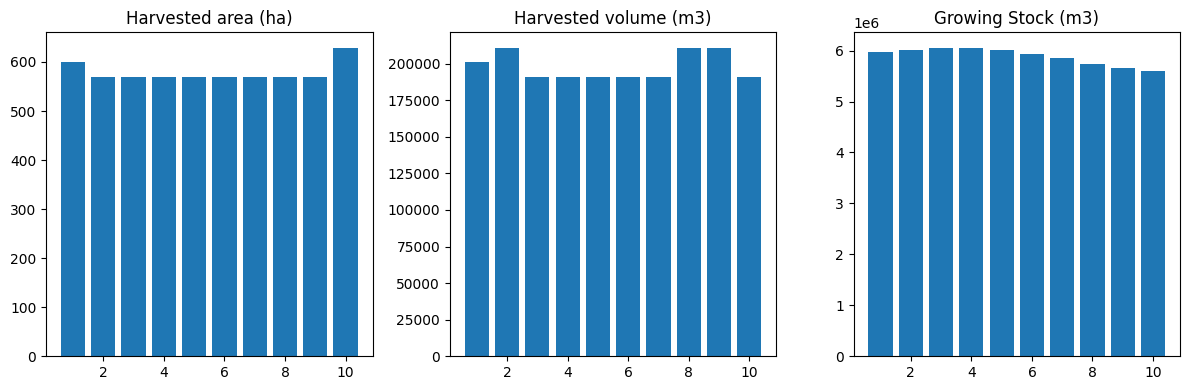

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


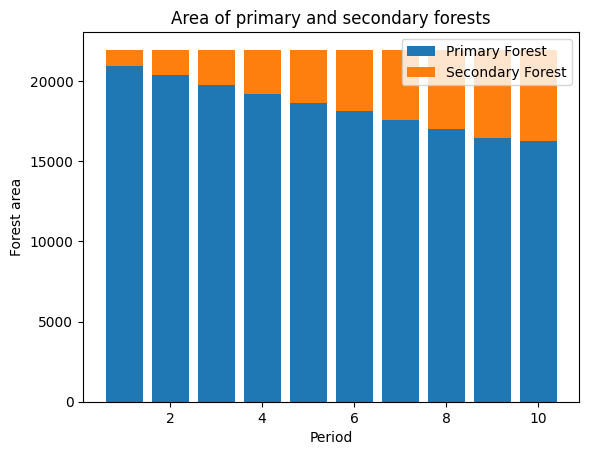

------------------------------------------------
The scocial indicator (the number of job creation) is:  2091
The economic indicator (the provincial government revenues) is:  71321
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   732.606055   276.743571
Aspen      75.149189   201.083815   125.934626
Cedar     398.274360  1297.315617   899.041256
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5069.289647  1674.405154
Spruce   4649.351742  5257.164280   607.812538
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1436.838879   406.692518

Old growth has **increased** by 4056.62 hectares from time period 0 to time

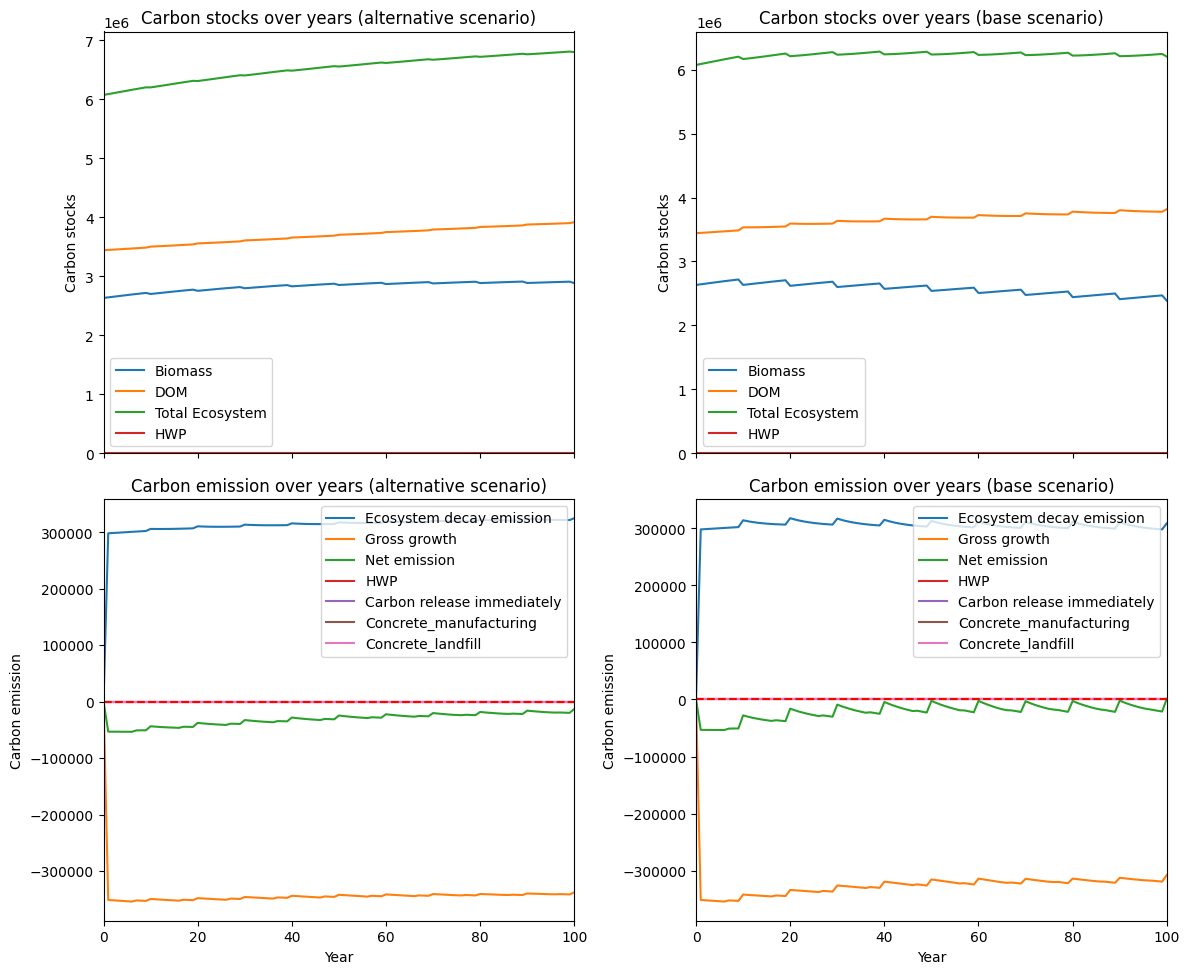

---------------------------------------------------------------------------------------
Net emission difference -1033688.4135026974
Net emission base scenario -2100094.913723152
Net emission alternative scenario -3133783.32722585
dollar_per_ton is:  9.674095084528009
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
DougFir  0.0   530.821386   530.821386
Aspen    0.0   134.986774   134.986774
Cedar    0.0   551.233414   551.233414
Pine     0.0     0.000000     0.000000
Bal      0.0   134.559979   134.559979
Spruce   0.0  1593.210904  1593.210904
Birch    0.0    14.026344    14.026344
Hem      0.0   117.515569   117.515569

Overall, the old growth area has **increased** by 3076.35 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
----------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


apply action error 1 ('tsa17', '1', '298', '204', '298', '1') harvest 1 91 -8.085702764838438e-09
apply action error 1 ('tsa17', '1', '265', '304', '265', '1') harvest 2 290 -2.5395616889786766e-11
apply action error 1 ('tsa17', '1', '379', '204', '379', '1') harvest 3 161 -2.050428020949934e-11
apply action error 1 ('tsa17', '1', '356', '500', '356', '1') harvest 4 134 -2.514857296837357e-09
apply action error 1 ('tsa17', '1', '1192', '100', '1192', '1') harvest 4 314 -5.608914147505753e-09
apply action error 1 ('tsa17', '1', '356', '500', '356', '1') harvest 5 144 -2.586511698217201e-11
apply action error 1 ('tsa17', '1', '336', '1211', '336', '1') harvest 6 164 -7.008054514307679e-11
apply action error 1 ('tsa17', '1', '265', '304', '265', '1') harvest 7 251 -4.925891797786645e-10
apply action error 1 ('tsa17', '1', '265', '304', '265', '1') harvest 7 384 -1.672819240501908e-09
apply action error 1 ('tsa17', '1', '357', '500', '357', '1') harvest 7 184 -7.315389957854808e-11
apply a

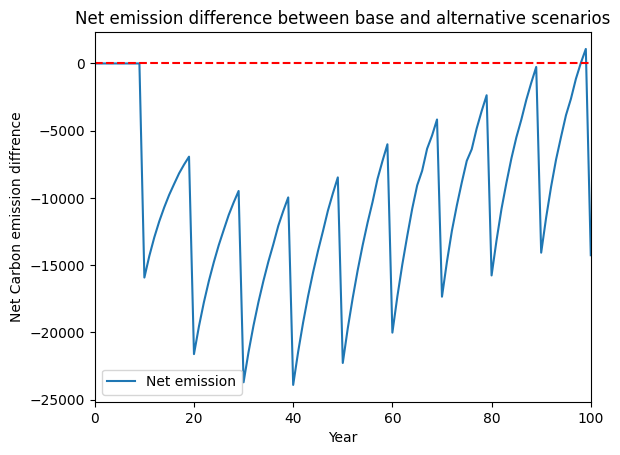

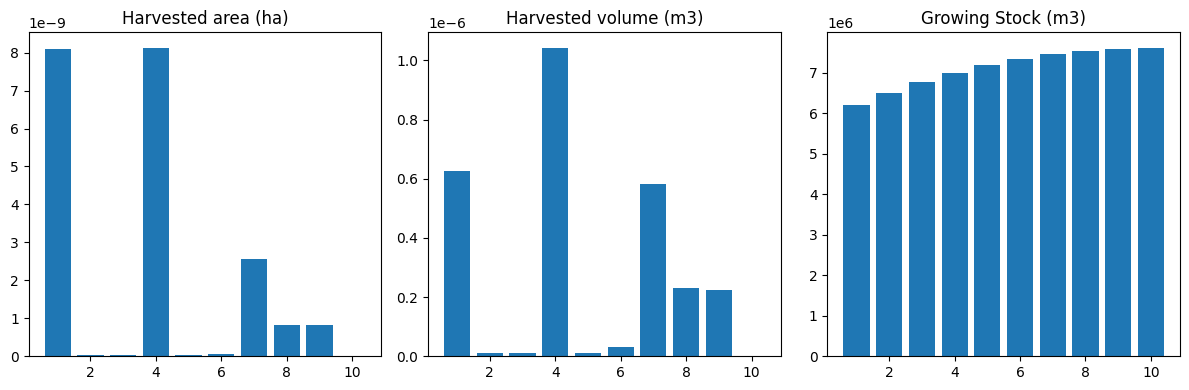

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_highest carbon stock_scheduling.pdf


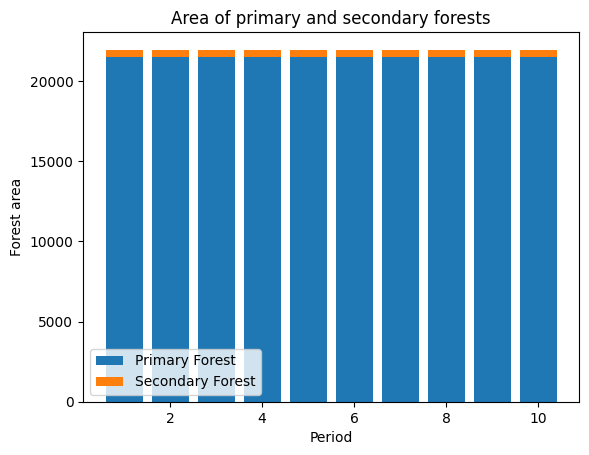

------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483  1273.304349   817.441865
Aspen      75.149189   561.728757   486.579567
Cedar     398.274360  2484.419907  2086.145547
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5203.849626  1808.965133
Spruce   4649.351742  7212.800170  2563.448428
Birch       5.900812    41.142246    35.241434
Hem      1030.146361  1587.452745   557.306383

Old growth has **increased** by 8399.90 hectares from time period 0 to time per

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


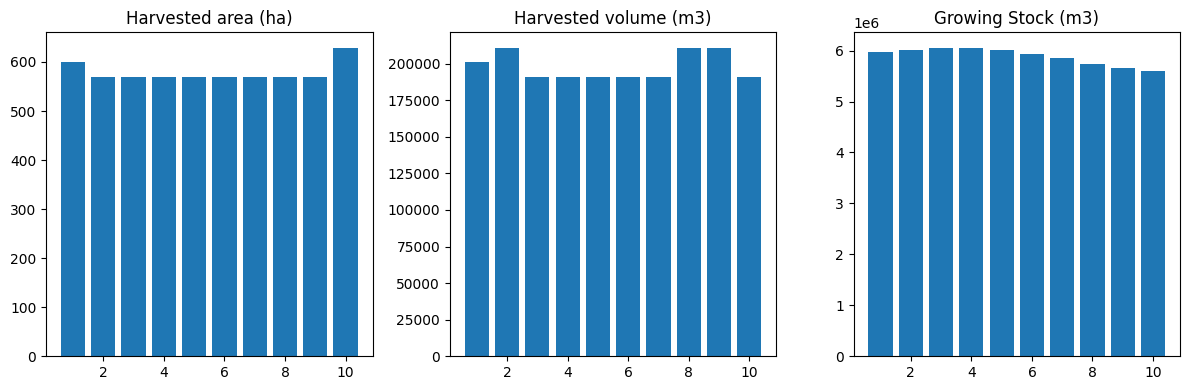

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


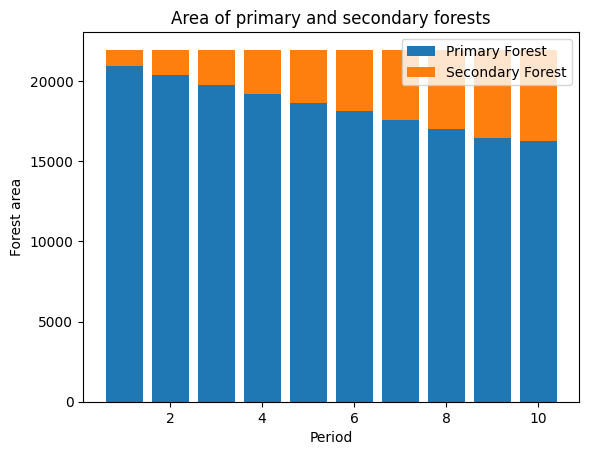

------------------------------------------------
The scocial indicator (the number of job creation) is:  2091
The economic indicator (the provincial government revenues) is:  71321
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
DougFir   455.862483   732.606055   276.743571
Aspen      75.149189   201.083815   125.934626
Cedar     398.274360  1297.315617   899.041256
Pine      159.807528   204.577946    44.770418
Bal      3394.884493  5069.289647  1674.405154
Spruce   4649.351742  5257.164280   607.812538
Birch       5.900812    27.115901    21.215089
Hem      1030.146361  1436.838879   406.692518

Old growth has **increased** by 4056.62 hectares from time period 0 to time

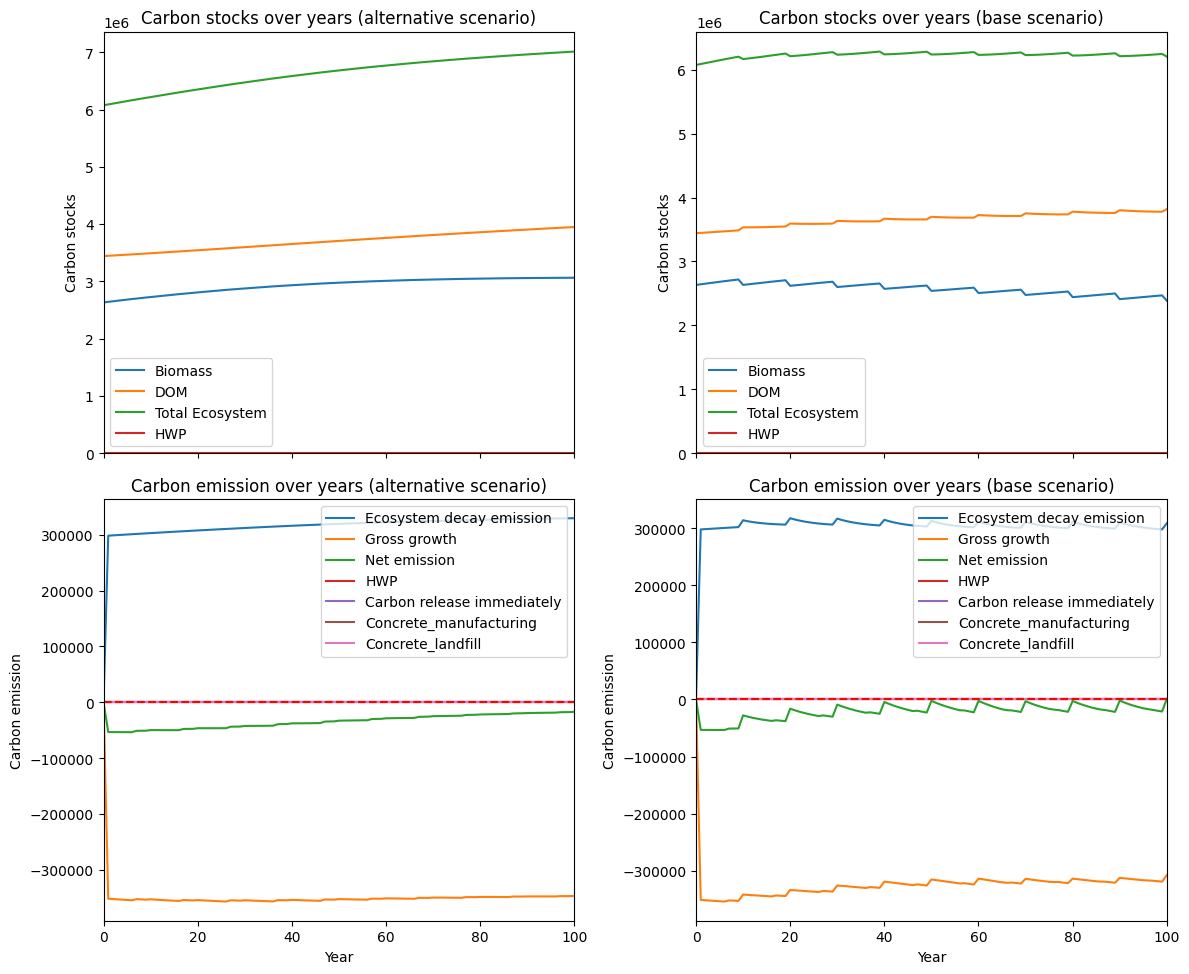

---------------------------------------------------------------------------------------
Net emission difference -1336173.8941841305
Net emission base scenario -2100094.913723152
Net emission alternative scenario -3436268.8079072833
dollar_per_ton is:  7.484055813039225
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
DougFir  0.0   540.698294   540.698294
Aspen    0.0   360.644942   360.644942
Cedar    0.0  1187.104290  1187.104290
Pine     0.0     0.000000     0.000000
Bal      0.0   134.559979   134.559979
Spruce   0.0  1955.635890  1955.635890
Birch    0.0    14.026344    14.026344
Hem      0.0   150.613866   150.613866

Overall, the old growth area has **increased** by 4343.28 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
--------

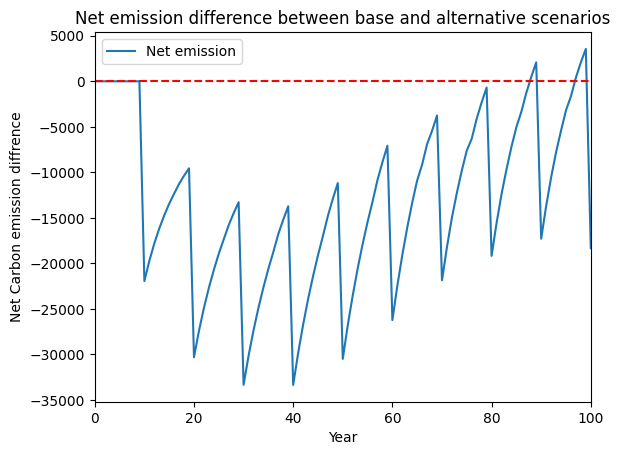

In [60]:
Start = time.time()

epsilon, cs_max = epsilon_computer(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=10, solver=ws3.opt.SOLVER_PULP)
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode, 
                      epsilon,
                      cs_max,
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

6941377.1987589905
[188738.32469129053, 196153.92660484774, 203363.4172756935, 210044.5609092703]
[6057822.0976809375, 6278710.871904253, 6499599.648531469, 6720488.4233767325]


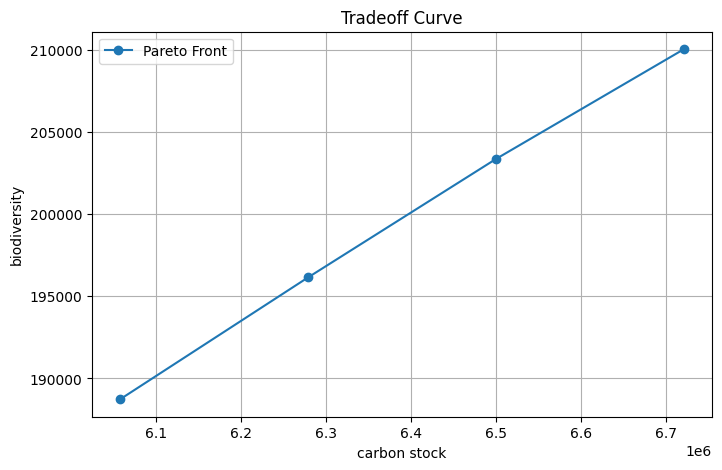

In [61]:
tradeoff_biodiversity_cs(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=4, solver=ws3.opt.SOLVER_PULP)

[5.255518887535305e-07, 697945.6481714193, 1329092.2413843372, 1881750.678689092, 2039009.5075575437]
[6941377.19875887, 6720488.423368765, 6499599.647572001, 6278710.872517763, 6094564.739430759]


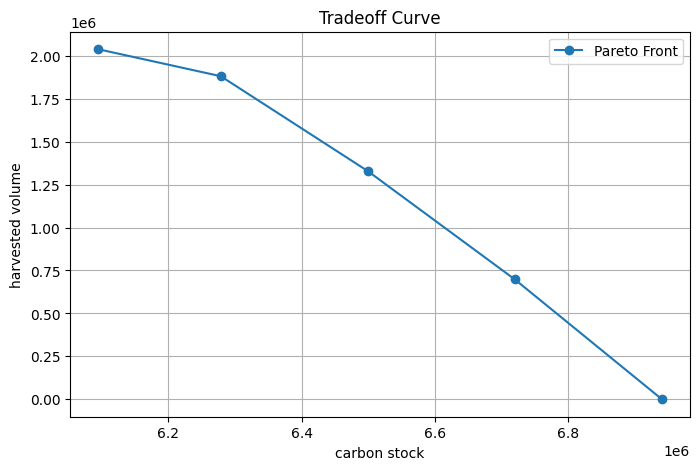

In [62]:
epsilon, cs_max = epsilon_computer(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=4, solver=ws3.opt.SOLVER_PULP)
tradeoff_hv_cs(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, epsilon, cs_max, n=4, solver=ws3.opt.SOLVER_PULP)

In [ ]:
tradeoff_hv_biodiversity(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=4, solver=ws3.opt.SOLVER_PULP)